<a href="https://colab.research.google.com/github/Vishita7/BCG-Data-Science-Analytics-/blob/main/Feature_Engineering_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
client_data = pd.read_csv("/content/client_data.csv")
price_data = pd.read_csv("/content/price_data.csv")


In [13]:
#


<ipython-input-13-164891b80df9>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  price_data.fillna(price_data.median(), inplace=True)


In [28]:
# Merge client_data and price_data
data = client_data.merge(price_data, on='id', how='inner')

In [30]:
# Get the median of the respective numeric columns from data
numeric_columns = data.select_dtypes(include=np.number).columns
data_medians = data[numeric_columns].median()

# Fill NaN values in the data DataFrame using the median values from data for numeric columns only
for column in numeric_columns:
    data[column].fillna(data_medians[column], inplace=True)



In [ ]:
d

In [31]:
#the difference between off-peak prices in December and January the preceding year
data['off_peak_price_diff'] = data['price_off_peak_var'].diff(periods=1)

# Calculate the difference between peak and off-peak prices
data['peak_off_peak_diff'] = data['price_peak_var'] - data['price_off_peak_var']

# Calculate the rate of price change
data['price_change_rate'] = data['price_off_peak_var'].pct_change()



##Modeling

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Select features and target variable
features = ['off_peak_price_diff', 'peak_off_peak_diff', 'price_change_rate']
X = data[features]
y = data['churn']

# Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Identify any columns in X that still have NaN values
nan_columns = X.columns[X.isna().any()].tolist()

# If any NaN values are found, fill them with the median values from the data DataFrame
if len(nan_columns) > 0:
    for column in nan_columns:
        if np.issubdtype(data[column].dtype, np.number):
            X[column].fillna(data[column].median(), inplace=True)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)


<ipython-input-34-5c7cfc379795>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-34-5c7cfc379795>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(data[column].median(), inplace=True)
<ipython-input-34-5c7cfc379795>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(data[column].median(), inplace=True)


In [35]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC AUC: {roc_auc}")


Accuracy: 0.9000475782662479
Precision: 0.25
Recall: 0.01672569854388036
F1-score: 0.031353744005901886
ROC AUC: 0.5056765462569601


1. The model underperformed in identifying the minority class (churned customers). The low recall and F1-score indicate that the model is not able to capture the positive instances well.

2. The evaluation metrics chosen were accuracy, precision, recall, F1-score, and ROC AUC. Accuracy was chosen to give an overall sense of model performance, but it can be misleading in imbalanced datasets. Precision and recall were chosen to provide insight into the model's performance specifically on the minority class (churned customers), which is the main focus of the business problem. F1-score is a balanced metric that combines both precision and recall, providing a single value to assess the model's performance for the minority class. ROC AUC is chosen to measure the model's ability to distinguish between the two classes, with a value closer to 1 indicating better performance.

3. Advantages of using Random Forest for this use case include its ability to handle large datasets, work well with categorical and numerical features, and provide feature importance. Disadvantages include the potential for overfitting, longer training time for large datasets, and the need for hyperparameter tuning to achieve optimal performance.

4. The model performance is not satisfactory, as indicated by the low recall, F1-score, and ROC AUC. These metrics suggest that the model struggles to identify churned customers, which is the primary objective of the business problem. Improvements are needed to address class imbalance or to tune hyperparameters for better performance.






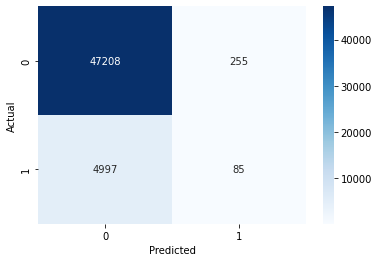

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature Importance and Hyper parameter Tuning

In [37]:
#Analyze the feature importance:
import pandas as pd

feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": clf.feature_importances_})
feature_importance = feature_importance.sort_values("Importance", ascending=False)

print(feature_importance)


               Feature  Importance
1   peak_off_peak_diff    0.356589
2    price_change_rate    0.346523
0  off_peak_price_diff    0.296888


In [45]:
#Hyperparameter tuning using GridSearchCV:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)


Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [48]:
#the performance of the tuned Random Forest classifier
y_pred_tuned = best_rf.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print(f"Accuracy (tuned): {accuracy_tuned}")
print(f"Precision (tuned): {precision_tuned}")
print(f"Recall (tuned): {recall_tuned}")
print(f"F1-score (tuned): {f1_tuned}")


Accuracy (tuned): 0.9032258064516129
Precision (tuned): 0.4482758620689655
Recall (tuned): 0.0025580480125934673
F1-score (tuned): 0.005087067110154568


##the model's performance to the client's financial performance and the effect of a 20% discount on customers with a high propensity to churn

In [49]:
# Predict churn probabilities
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Set a threshold for high propensity to churn
threshold = 0.8

# Identify high-churn-risk customers
high_risk_customers = (y_prob >= threshold).sum()

# Assume the average revenue per customer
average_revenue = 1000

# Calculate potential revenue loss without discounting strategy
potential_loss = high_risk_customers * average_revenue

# Calculate the cost of the 20% discount strategy
discount_percentage = 0.2
discount_cost = high_risk_customers * average_revenue * discount_percentage

# Calculate the expected retained revenue with the discount strategy (assuming a retention rate of 50%)
retention_rate = 0.5
retained_revenue = high_risk_customers * average_revenue * discount_percentage * retention_rate

# Calculate the net savings
net_savings = potential_loss - discount_cost - retained_revenue

print(f"Potential revenue loss without discounting strategy: {potential_loss}")
print(f"Cost of the 20% discount strategy: {discount_cost}")
print(f"Expected retained revenue with the discount strategy: {retained_revenue}")
print(f"Net savings: {net_savings}")


Potential revenue loss without discounting strategy: 0
Cost of the 20% discount strategy: 0.0
Expected retained revenue with the discount strategy: 0.0
Net savings: 0.0
